In [6]:
import config

from tqdm import tqdm
import warnings
import os
from hyena_dna.standalone_hyenadna import HyenaDNAModel
import torch
import pickle
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore')
os.chdir(config.DIR_ROOT)

In [3]:
path_to_df_info = os.path.join(config.DIR_INCEST_MANY, 'repbase_orf_type.txt')
df_info = pd.read_csv(path_to_df_info, sep='\t')
df_info

,name,MainType,SubType,Length,Good
0,Gypsy-5_AnMe-I_Gypsy_Anopheles_merus,LTR retrotransposon,Ty3/gypsy,4369,1
1,Gypsy-6_AnFu-LTR_Gypsy_Anopheles_funestus,LTR retrotransposon,Ty3/gypsy,391,0
2,CR1-8_AG_CR1_Anopheles_gambiae,Non-LTR retrotransposon,LINE/CR1,1899,1
3,Mariner-N15_AG_Mariner/Tc1_Anopheles_gambiae,DNA transposon,Tc1/Mariner,249,0
4,Gypsy-3_AnMe-I_Gypsy_Anopheles_merus,LTR retrotransposon,Ty3/gypsy,4461,1
...,...,...,...,...,...
100493,BEL2-LTR_DR_BEL_Danio_rerio,LTR retrotransposon,Ty3/gypsy,890,0
100494,Gypsy101-I_DR_Gypsy_Danio_rerio,LTR retrotransposon,Ty3/gypsy,4305,1
100495,Gypsy36-I_DR_Gypsy_Danio_rerio,LTR retrotransposon,Ty3/gypsy,5367,1
100496,hAT-N201_DR_hAT_Danio_rerio,DNA transposon,hAT,694,0


In [5]:
df_info_filter = df_info[df_info['Good'] == 1]
df_info_filter

,name,MainType,SubType,Length,Good
0,Gypsy-5_AnMe-I_Gypsy_Anopheles_merus,LTR retrotransposon,Ty3/gypsy,4369,1
2,CR1-8_AG_CR1_Anopheles_gambiae,Non-LTR retrotransposon,LINE/CR1,1899,1
4,Gypsy-3_AnMe-I_Gypsy_Anopheles_merus,LTR retrotransposon,Ty3/gypsy,4461,1
5,GYPSY22-I_AG_Gypsy_Anopheles_gambiae,LTR retrotransposon,Ty3/gypsy,4383,1
8,Copia-8_AnFu-I_Copia_Anopheles_funestus,LTR retrotransposon,Ty1/copia,4073,1
...,...,...,...,...,...
100491,hAT-47_DR_hAT_Danio_rerio,DNA transposon,hAT,4799,1
100492,Gypsy-193_DR-I_Gypsy_Danio_rerio,LTR retrotransposon,Ty3/gypsy,4324,1
100494,Gypsy101-I_DR_Gypsy_Danio_rerio,LTR retrotransposon,Ty3/gypsy,4305,1
100495,Gypsy36-I_DR_Gypsy_Danio_rerio,LTR retrotransposon,Ty3/gypsy,5367,1


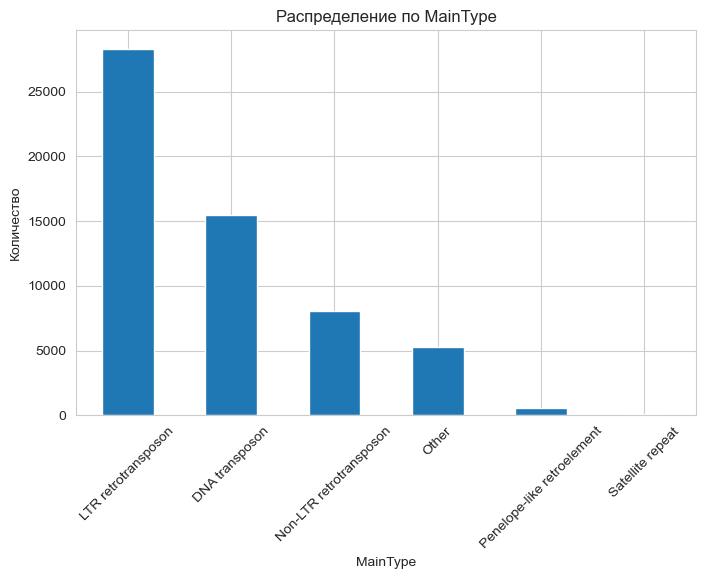

In [7]:
counts = df_info_filter['MainType'].value_counts()

plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.title("Распределение по MainType")
plt.xlabel("MainType")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.show()

In [9]:
np.unique(df_info_filter['MainType'])

array(['DNA transposon', 'LTR retrotransposon', 'Non-LTR retrotransposon',
       'Other', 'Penelope-like retroelement', 'Satellite repeat'],
      dtype=object)

In [10]:
keep = ['DNA transposon', 'LTR retrotransposon', 'Non-LTR retrotransposon']
n = df_info_filter[df_info_filter['MainType'].isin(keep)]['MainType'].value_counts().min()
df = df_info_filter[df_info_filter['MainType'].isin(keep)].groupby('MainType', group_keys=False).apply(lambda x: x.sample(n))

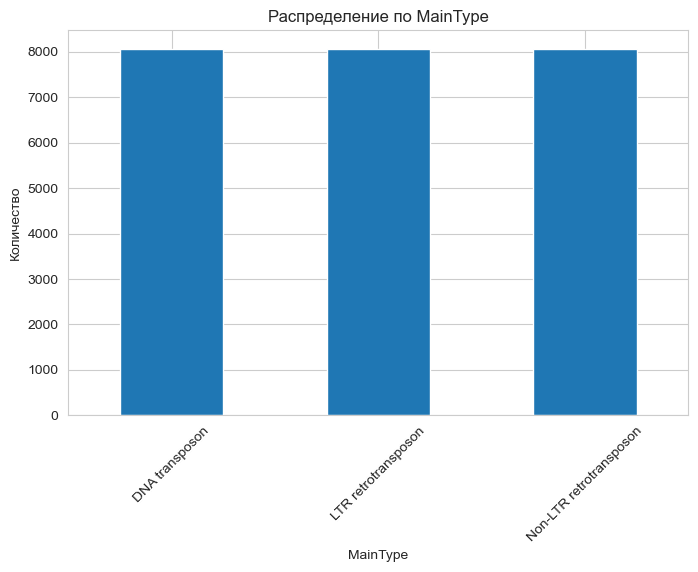

In [11]:
counts = df['MainType'].value_counts()

plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.title("Распределение по MainType")
plt.xlabel("MainType")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.show()

In [12]:
df

,name,MainType,SubType,Length,Good
29434,ISL2EU-51_CGi_ISL2EU_Crassostrea_gigas,DNA transposon,IS-like/prokaryotic,2941,1
32746,Kolobok-6_LMi_Kolobok_Locusta_migratoria,DNA transposon,Kolobok,1579,1
60212,Transib-2N1_DTa_Transib_Drosophila_takahashii,DNA transposon,Transib,1334,1
21249,Tad1-13B_BG_Tad1_Blumeria_graminis,DNA transposon,hAT/Tad1,3824,1
22682,MuDR-20_TAe_MuDR_Triticum_aestivum,DNA transposon,MuDR/Mutator,4609,1
...,...,...,...,...,...
99795,L2-46_DR_L2_Danio_rerio,Non-LTR retrotransposon,LINE/L1/L2,2517,1
78943,L1Lx_II_L1_Mus_musculus,Non-LTR retrotransposon,LINE/L1/L2,6088,1
71716,LINE1-N1H_OS_L1_Oryza_sativa,Non-LTR retrotransposon,LINE/L1/L2,1253,1
69180,PteBra-2.35_L1_Pteronura_brasiliensis,Non-LTR retrotransposon,LINE/L1/L2,7031,1


In [13]:
path_to_df_info = os.path.join(config.DIR_INCEST_MANY, 'repbase_filtered.csv')
df.to_csv(path_to_df_info, index=False)